# Liver Model Construction: Notebook

In [150]:
import os
import re
import warnings
from cobra.io import *
from cobra.io.json import *
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
from cobra.io.json import *
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
from cobra.io.json import load_json_model
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [151]:
import sys
# from minspan import minspan,nnz
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [152]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")
# extra_dir=os.path.abspath("..")
# minspan_dir

### Getting reactions and metabolite data from RECON 3D

In [153]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"core_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')



# making dataframe of reactions
csv_rxn = os.path.join(data_dir,"core_reaction_df.csv")
rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
reaction_info = rxn_csv_df.to_dict(orient='index')

### Loading cobra model

In [154]:
# Initiate empty model
trial= cobra.Model()

In [155]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [156]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"core_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [157]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

NADH2_u10mi
FADH2ETC
CYOR_u10mi
CYOOm2i
ATPS4mi
Htmi
CSm
ACONTm
ICDHxm
AKGDm
SUCOASm
SUCD1m
FUMm
MDHm
PDHm
PCm
PEPCKm
FBP
MALtm
MDH
PEPCK_re
HCO3Em
ATPtm
AKGMALtm
ASPTA
ASPTAm
PYRt2m
ASPGLUm
O2tm
H2Otm
CO2tm
NDPK1m
NDPK1
ATPM
HEX1
PGI
PFK
FBA
TPI
GAPD
PGK
PGM
ENO
PYK
LDH_L
G6PDH2r
PGL
GND
RPI
RPE
TKT1
TKT2
TALA
SPODM
GTHPi
GTHOr


In [158]:
len(trial.reactions)

56

In [159]:
# #adding DM_NADH 
# nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
# rxn = cobra.Reaction('DM_nadh')
# trial.add_reaction(rxn)
# rxn.add_metabolites(nadhm)




peptm = {'pep_m': -1, 'pi_c': -1, 'pi_m': 1, 'pep_c':1}
rxn2 = cobra.Reaction('PEPtm')
rxn2.lower_bound=0
trial.add_reaction(rxn2)
rxn2.add_metabolites(peptm)



# g6pase = {'g6p_c': -1, 'h2o_c': -1, 'pi_c': 1, 'glc__D_c':1}
# rxn3 = cobra.Reaction('G6PP')
# trial.add_reaction(rxn3)
# rxn3.add_metabolites(g6pase)

htm = {'h_c': -1,  'h_m': 1}
rxn4 = cobra.Reaction('Htm')
trial.add_reaction(rxn4)
rxn4.add_metabolites(htm)

pitm = {'h_i': -1,'pi_c': -1,  'h_m': 1,  'pi_m': 1}
rxn5 = cobra.Reaction('PItm')
trial.add_reaction(rxn5)
rxn5.lower_bound=0
rxn5.add_metabolites(pitm)
# # 
# # nadph_c --> h_c + nadp_c
nadphm = {'nadph_c': -1, 'h_c': 1,  'nadp_c': 1}
rxn6 = cobra.Reaction('NADPHM')
trial.add_reaction(rxn6)
rxn6.lower_bound=0
rxn6.add_metabolites(nadphm)

# ## add PEPtm and g6paseb ['Htm', 'PItm',  'NADPHM',

# #  'PEPtm',
# #  'EX_co2_c',
# #  'EX_o2_c',
# #  'EX_h_c',
# #  'EX_h2o_c',
# #  'EX_pi_c',
# #  'EX_glc__D_c',
# #  'EX_lac__L_c',

# #  'EX_r5p_c',
# #  'EX_o2s_c']


In [160]:
# trial.reactions.G6PP.lower_bound=0
len(trial.reactions)

60

In [161]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

NADH2_u10mi {'charge': 1.0}
FADH2ETC {}
CYOR_u10mi {'charge': -2.0}
CYOOm2i {'charge': 4.0}
ATPS4mi {'charge': -1.0}
Htmi {}
CSm {'charge': -1.0}
ACONTm {}
ICDHxm {}
AKGDm {}
SUCOASm {'charge': 2.0}
SUCD1m {}
FUMm {}
MDHm {'charge': -1.0}
PDHm {}
PCm {'charge': 1.0}
PEPCKm {}
FBP {'charge': 2.0}
MALtm {}
MDH {'charge': -1.0}
PEPCK_re {}
HCO3Em {'charge': -1.0}
ATPtm {}
AKGMALtm {}
ASPTA {}
ASPTAm {}
PYRt2m {}
ASPGLUm {}
O2tm {}
H2Otm {}
CO2tm {}
NDPK1m {}
NDPK1 {}
ATPM {'charge': 1.0}
HEX1 {'charge': -1.0}
PGI {}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
LDH_L {'charge': -1.0}
G6PDH2r {'charge': -1.0}
PGL {'charge': -1.0}
GND {}
RPI {}
RPE {}
TKT1 {}
TKT2 {}
TALA {}
SPODM {'charge': 2.0}
GTHPi {}
GTHOr {'charge': 1.0}
PEPtm {}
Htm {}
PItm {}
NADPHM {'charge': 1}


In [162]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

NADH2_u10mi {'charge': 1.0}
FADH2ETC {}
CYOR_u10mi {'charge': -2.0}
CYOOm2i {'charge': 4.0}
ATPS4mi {'charge': -1.0}
Htmi {}
CSm {'charge': -1.0}
ACONTm {}
ICDHxm {}
AKGDm {}
SUCOASm {'charge': 2.0}
SUCD1m {}
FUMm {}
MDHm {'charge': -1.0}
PDHm {}
PCm {'charge': 1.0}
PEPCKm {}
FBP {'charge': 2.0}
MALtm {}
MDH {'charge': -1.0}
PEPCK_re {}
HCO3Em {'charge': -1.0}
ATPtm {}
AKGMALtm {}
ASPTA {}
ASPTAm {}
PYRt2m {}
ASPGLUm {}
O2tm {}
H2Otm {}
CO2tm {}
NDPK1m {}
NDPK1 {}
ATPM {'charge': 1.0}
HEX1 {'charge': -1.0}
PGI {}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
LDH_L {'charge': -1.0}
G6PDH2r {'charge': -1.0}
PGL {'charge': -1.0}
GND {}
RPI {}
RPE {}
TKT1 {}
TKT2 {}
TALA {}
SPODM {'charge': 2.0}
GTHPi {}
GTHOr {'charge': 1.0}
PEPtm {}
Htm {}
PItm {}
NADPHM {'charge': 1}


In [163]:
for met in ['glc__D_c',
#  'pyr_c', 
'h2o_c', 'h_c', 'pi_c','lac__L_c','co2_c','o2_c','o2s_c','r5p_c']:
    # DOUBLE CHECK PYRUVATE EXCHANGE
    rxn = cobra.Reaction('EX_%s' % met)
    
    trial.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # by convention negative exchange flux = uptake
    elif met == 'r5p_c' or met == 'lac__L_c' or met == 'lac__L_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

In [164]:
trial.metabolites.h_c.charge= 1
trial.metabolites.h_m.charge= 1
trial.metabolites.h_i.charge= 1
trial.metabolites.pi_c.charge= -2
trial.metabolites.pi_m.charge= -2

In [165]:
# solved_fluxes = minspan(trial, cores=3, verbose=False, timelimit=60)
# from model_dir import minspan
# df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in trial.reactions])
# df = df/df.abs().max()
# csv = os.path.join(data_dir,"minspan_trial 1")
# df.to_csv(csv  % model_name)

In [166]:
len(trial.reactions)

69

In [167]:
trial.objective = 'ATPS4mi'
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
NADH2_u10mi,10.000000,-2.220446e-16
FADH2ETC,2.000000,0.000000e+00
CYOR_u10mi,12.000000,0.000000e+00
CYOOm2i,6.000000,0.000000e+00
ATPS4mi,25.384615,-5.551115e-17
...,...,...
EX_lac__L_c,0.000000,-2.538462e+01
EX_co2_c,6.000000,0.000000e+00
EX_o2_c,-6.000000,-0.000000e+00
EX_o2s_c,0.000000,-0.000000e+00


In [168]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),highlight_missing=True)
# try this (below)
# The reactions and metabolites to be added in this exercise
# builder = escher.Builder(map_json='%s/gly_ppp_tca_etc_map.json'% resource_dir)
# builder
# escher_builder

# escher_builder = escher.Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"gly_ppp_tca.json"),highlight_missing=True)

# escher_builder


In [169]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'NADH2_u10mi': 10.0, 'FADH2ETC': 2.0, 'CYOR_u10mi': 12.0, 'CYOOm2i': 6.0, 'ATPS4mi': 25…

In [170]:
trial.reactions.ATPS4mi

Reaction identifier,ATPS4mi
Name,ATP synthase (four protons for one ATP)
Memory address,0x01e5b0150610
Stoichiometry,adp_m + 4.0 h_i + pi_m --> atp_m + h2o_m + 3.0 h_m ADP C10H12N5O10P2 + 4.0 H+ + Phosphate --> ATP C10H12N5O13P3 + H2O H2O + 3.0 H+
GPR,
Lower bound,0.0
Upper bound,1000.0


In [171]:
from cobra.io.json import load_json_model as load_json_cobra_model

In [ ]:
glycolysis_ppp_tca_etc= load_json_cobra_model(filename=os.path.join(model_dir,"glycolysis_ppp_tca_etc_model.json"))

In [172]:
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [173]:
R3D.reactions.ATPS4mi

Reaction identifier,ATPS4mi
Name,ATP synthase (four protons for one ATP)
Memory address,0x01e5cd7e02e0
Stoichiometry,adp_m + 4.0 h_i + pi_m --> atp_m + h2o_m + 3.0 h_m ADP C10H12N5O10P2 + 4.0 H+ + Phosphate --> ATP C10H12N5O13P3 + H2O H2O + 3.0 H+
GPR,((513_AT1 and 498_AT2 and 506_AT1 and 509_AT2 and 514_AT1) or (498_AT2 and 513_AT2 and 514_AT2...
Lower bound,0.0
Upper bound,1000.0


In [174]:
from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob



In [175]:

# gly_gluco_json = os.path.join(model_dir,"gly_gluco_json.json")
# cobra.io.save_json_model(trial, gly_gluco_json )

In [176]:
core_json = os.path.join(model_dir,"gly_ppp_tca.json")
json.save_json_model(model=trial, filename=core_json)

In [177]:
# import cplex as cplex
# import gurobipy as gurobi

In [178]:
# trial.solver.add("gurobi")
# trial.solver='cplex'
# cobra.util.solver.qp_solvers = ['cplex', 'gurobi']
# trial.solver

In [179]:
for model_file in glob(core_json):
    model_name = model_file.split('/')[-1]
    if 'model' not in model_name:
        continue
    print(model_name)
    model= load_json_model(model_file)
    if 'NADPHM' in model.reactions:
        model.remove_reactions(['NADPHM'])
    # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
    #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
    #         'EX_etoh_c', 'EX_fru_c']
    media = ['EX_glc__D_c']
    for met in media:
        if met in model.reactions:
            model.reactions.get_by_id(met).lower_bound = -1000.

    rxns = [i.id for i in model.reactions]
    #removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
    # blocked = cobra.flux_analysis.find_blocked_reactions(model)
    # print(blocked)
    # model.remove_reactions(blocked)

    solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
    df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
    df = df/df.abs().max()
    for col in range(len(df.columns)):
        column=df.iloc[:,col]
        vals = column.values
        min_val = min([abs(i) for i in vals if i != 0])
        corr_fac=1/min_val
        # print(corr_fac)
        vals=vals*abs(corr_fac)
        df['Norm'+ str(col)]=vals
    ### normalise each column by the min  qty in the column
    csv_dir = os.path.join(minspan_dir,"gly_ppp_tca_csv_2.csv")
    df.to_csv(csv_dir)

c:\Users\sicil\LiverModel\models\gly_ppp_tca.json
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp4fo5uxlc.lp
Reading time = 0.01 seconds
: 74 rows, 136 columns, 512 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpi2nvu0uj.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpocqvizs6.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp4myphrqd.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpxxizxuda.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpeww03j6s.lp
Reading time = 0.01 seconds
: 210 rows, 204 columns, 888 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp51o8ebz

In [180]:
## WHere it's stored
csv_minspan_dir = os.path.join(minspan_dir,"gly_ppp_tca_csv.csv")

In [181]:
df = pd.read_csv(csv_minspan_dir,index_col=0) 
df

,0,1,2,3,4,5,6,7,8,9,Norm0,Norm1,Norm2,Norm3,Norm4,Norm5,Norm6,Norm7,Norm8,Norm9
NADH2_u10mi,0.090909,0.0,0.086614,0.088889,0.000000,0.00,0.000000,0.0,0.333333,0.379562,5.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,4.0,4.000000
FADH2ETC,0.018182,0.0,0.023622,0.022222,0.000000,0.00,0.000000,0.0,0.083333,0.094891,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000
CYOR_u10mi,0.109091,0.0,0.110236,0.111111,0.000000,0.00,0.000000,0.0,0.416667,0.474453,6.0,0.0,14.0,5.0,0.0,0.0,0.0,0.0,5.0,5.000000
CYOOm2i,0.054545,0.0,0.055118,0.055556,0.000000,0.00,0.000000,0.0,0.208333,0.237226,3.0,0.0,7.0,2.5,0.0,0.0,0.0,0.0,2.5,2.500000
ATPS4mi,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.750000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_lac__L_c,-0.018182,1.0,-0.023622,-0.022222,0.666667,0.00,0.666667,0.0,-0.083333,-0.094891,-1.0,2.0,-3.0,-1.0,2.0,0.0,2.0,0.0,-1.0,-1.000000
EX_co2_c,0.054545,0.0,0.070866,0.066667,0.000000,0.25,0.000000,0.0,0.250000,0.284672,3.0,0.0,9.0,3.0,0.0,5.0,0.0,0.0,3.0,3.000000
EX_o2_c,-0.054545,0.0,-0.055118,-0.055556,0.000000,0.50,0.000000,0.0,-0.208333,-0.237226,-3.0,0.0,-7.0,-2.5,0.0,10.0,0.0,0.0,-2.5,-2.500000
EX_o2s_c,0.000000,0.0,0.000000,0.000000,0.000000,-1.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-20.0,0.0,0.0,0.0,0.000000


In [182]:
initial_minspan_data = {
    reaction: flux
    for reaction, flux in df.iloc[:,19].iteritems()}

In [183]:
import escher
from escher import Builder

In [184]:
# #view all the reactions that we need build
# escher_builder = escher.Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"Glycolysis_Gluconeogenesis.json")
#     , reaction_data=initial_flux_data)


# New instance to prevent modifications to the existing maps
escher_builder = Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),
    reaction_data=initial_minspan_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'NADH2_u10mi': 4.0, 'FADH2ETC': 1.0, 'CYOR_u10mi': 5.0, 'CYOOm2i': 2.5, 'ATPS4mi': 10.5…

In [185]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [186]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=met_df.append(df_2)

met_df=met_df.set_index('id')
met_df

,name,charge,formula,compartment
id,,,,
h_i,H+,1,H,i
h_m,H+,1,H,m
nad_m,Nicotinamide adenine dinucleotide,-1,C21H26N7O14P2,m
nadh_m,Nicotinamide adenine dinucleotide - reduced,-2,C21H27N7O14P2,m
q10_m,Ubiquinone-10,0,C59H90O4,m
...,...,...,...,...
e4p_c,D-Erythrose 4-phosphate,-2,C4H7O7P,c
h2o2_c,Hydrogen peroxide,0,H2O2,c
o2s_c,Superoxide anion,-1,O2,c


In [187]:
csv_met_cobra = os.path.join(data_dir,"core_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [188]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df=rxn_df.append(df)

rxn_df=rxn_df.set_index('id')
rxn_df

,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,objective_coefficient
id,,,,,,
NADH2_u10mi,NADH2 u10mi,"{'h_i': 4.0, 'h_m': -5.0, 'nad_m': 1.0, 'nadh_...",0.0,1000.0,,NaN
FADH2ETC,Complex II reaction for respiratory chain,"{'fad_m': 1.0, 'fadh2_m': -1.0, 'q10_m': -1.0,...",0.0,1000.0,,NaN
CYOR_u10mi,CYOR u10mi,"{'ficytC_m': -2.0, 'focytC_m': 2.0, 'h_i': 4.0...",0.0,1000.0,,NaN
CYOOm2i,CYOOm2i,"{'ficytC_m': 4.0, 'focytC_m': -4.0, 'h2o_m': 2...",0.0,1000.0,,NaN
ATPS4mi,ATP synthase (four protons for one ATP),"{'adp_m': -1.0, 'atp_m': 1.0, 'h2o_m': 1.0, 'h...",0.0,1000.0,,1.0
...,...,...,...,...,...,...
EX_lac__L_c,,{'lac__L_c': -1},0,1000.0,,NaN
EX_co2_c,,{'co2_c': -1},-1000,1000.0,,NaN
EX_o2_c,,{'o2_c': -1},-1000,1000.0,,NaN


In [189]:
json_rxn_cobra = os.path.join(data_dir,"core_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra
,orient="index"
)
json_rxn_cobra

'c:\\Users\\sicil\\LiverModel\\data\\core_cobra_rxn.json'

## Making MASS model of glycolysis

In [190]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [191]:
import json
## make excluded list for reactions not needed in cc
# make a string split for 13dpg etc

In [192]:
# making dataframe of metabolites

met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

# making dataframe of reactions
# csv_rxn = os.path.join(data_dir,"glycolysis_gluconeogenesis_reaction_df.csv")
# rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
# reaction_info = rxn_csv_df.to_dict(orient='index')

In [193]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [194]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
#     if reaction_obj.id != "DM_nadh" or reaction_obj.id != 'ATPM':
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

## Setting initial conditions

In [195]:
import csv
import openpyxl

In [196]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [197]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations.xlsx")
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)
ic_info_all

,ID,Name,Concentration (mM),Concentration (M),Additional Notes
0,2pg_c,D-Glycerate 2-phosphate/ 2-\nPhosphoglycerate,0.110561,1.105609e-04,Data Source: HEPATOKIN
1,3hhcoa_m,NaN,0.000000,0.000000e+00,NaN
2,3hoctACP_c,NaN,0.000000,0.000000e+00,NaN
3,3pg_c,3-Phospho-D-glycerate/ 3-\nPhosphoglycerate,0.520630,5.206305e-04,NaN
4,aacoa_m,Acetoacetyl-CoA,0.000608,6.083800e-07,NaN
...,...,...,...,...,...
88,udp_c,UDP C9H11N2O12P2,0.315888,3.158882e-04,NaN
89,udpg_c,UDPglucose,0.679781,6.797807e-04,NaN
90,urea_c,Urea CH4N2O,31.939803,3.193980e-02,NaN
91,utp_c,UTP C9H11N2O15P3,0.882147,8.821469e-04,NaN


In [198]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

,Concentration (M)
ID,
2pg_c,1.105609e-04
3hhcoa_m,0.000000e+00
3hoctACP_c,0.000000e+00
3pg_c,5.206305e-04
aacoa_m,6.083800e-07
...,...
udp_c,3.158882e-04
udpg_c,6.797807e-04
urea_c,3.193980e-02


In [199]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            row = [mid,ic_value]
            # column = [ic_value]
            ic_info.append(row)
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
nad_m: 8.33773e-06
nadh_m: 0.000288577105
o2_m: 0.0
adp_m: 0.008038905800000001
atp_m: 0.00919
pi_m: 0.00045
accoa_m: 0.0013732010000000001
cit_m: 0.0060226752
coa_m: 0.0015432010000000001
oaa_m: 3.119e-05
icit_m: 4.2000000000000004e-05
akg_m: 0.001605
succoa_m: 0.00013000000000000002
succ_m: 0.000633435475
fum_m: 0.0084280308
mal__L_m: 0.002703530905
pyr_m: 0.00134
pep_m: 0.0020499999999999997
f6p_c: 0.00012713765
fdp_c: 5.1470825000000004e-05
pi_c: 0.0064
mal__L_c: 0.0015219999999999997
nad_c: 0.00182530972
nadh_c: 4.635419999999999e-06
oaa_c: 1.44886e-06
pep_c: 0.00031
adp_c: 0.00199495195
atp_c: 0.00472714598
akg_c: 0.0006381817949999999
asp__L_c: 0.008545
glu__L_c: 0.007055
asp__L_m: 0.0037829256
glu__L_m: 0.013795
pyr_c: 0.00047999999999999996
o2_c: 0.0
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
dhap_c: 0.00017689737000000004
3pg_c: 0.000520630485
2pg_c: 0.000110560855
lac__L_c: 0.00326183772
nadp_c: 0.000475236185
ru5p__D_c: 2.842

In [200]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
# liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x01e5c085cac0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


### Getting Standard and Physiological Gibbs energies of reactions

In [201]:
met_list = []
liver.boundary_conditions
for reaction in liver.boundary_conditions:
    print(reaction)

In [202]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")
excluded_reactions=["ATPM", 
# "NADHM",
#transport reactions
'NADPHM', "PYRt2m","PEPtm", 'Htmi','MALtm', 'ATPtm', 'AKGMALtm','O2tm','H2Otm',  'CO2tm', 'PItm' ,'Htm' ]

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))


# Trying to set these as 1e6 becasue the inf might be messing with the solver
liver.reactions.ATPM.Keq=1e6
liver.reactions.NADPHM.Keq=1e6


# liver.reactions.PEPtm.Keq=1
# liver.reactions.PYRt2m.Keq=1

Boundary Reactions and Values
-----------------------------
EX_glc__D_c: glc__D_c <=> 
glc__D_b: 0.01048280703

EX_pi_c: pi_c <=> 
pi_b: 0.0064

EX_lac__L_c: lac__L_c <=> 
lac__L_b: 0.00326183772

EX_o2_c: o2_c <=> 
o2_b: 0.0

EX_r5p_c: r5p_c <=> 
r5p_b: 7.72171e-06



In [203]:
reaction_str= []

cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp as exp
# Keq_df=pd.DataFrame(columns=["Reaction","Keq"])


In [204]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        # print(reaction_to_parse)
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
    #         print(f"ΔG'° = {dG0_prime}")
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")
#         list_keq=[reaction,a]
#         rxn_keq=pd.DataFrame(list_keq)
        df = pd.DataFrame([[reaction,a]], columns=["Reaction","Keq"])
        Keq_df.append(df)

# Keq_df    

NADH2_u10mi
Keq = 1.1097827514444105e+22
FADH2ETC
Keq = 5.023025404471424e+19
CYOR_u10mi


C:\Users\sicil\miniconda3\envs\massliver\lib\site-packages\equilibrator_cache\reaction.py:616 UserWarning: Cannot calculate Legendre transform for Compound(id=4914, inchi_key=None): Compound(id=4914, inchi_key=None) has not yet been analyzed by ChemAxon.
C:\Users\sicil\miniconda3\envs\massliver\lib\site-packages\equilibrator_cache\reaction.py:616 UserWarning: Cannot calculate Legendre transform for Compound(id=704, inchi_key=None): Compound(id=704, inchi_key=None) has not yet been analyzed by ChemAxon.


Keq = 1.0737921585425147e+24
CYOOm2i
Keq = 0.0009020643675317233
ATPS4mi
Keq = 5.976530315538269e-09
CSm
Keq = 3825036.234120267
ACONTm
Keq = 0.08298137980719675
ICDHxm
Keq = 132.56877597611685
AKGDm
Keq = 42244.831063136786
SUCOASm
Keq = 1.4643104514453096
SUCD1m
Keq = 4.997902379212323e-08
FUMm
Keq = 3.772878492916711
MDHm
Keq = 4.7812151480308246e-05
PDHm
Keq = 557041.79687703
PCm
Keq = 26.659254851731617
PEPCKm
Keq = 5.8718785452391975
FBP
Keq = 115004.76795942851
MDH
Keq = 4.7812151480308246e-05
PEPCK_re
Keq = 5.8718785452391975
HCO3Em
Keq = 33.18076124208141
ASPTA
Keq = 0.33333387781666934
ASPTAm
Keq = 0.33333387781666934
ASPGLUm
Keq = 1.0
NDPK1m
Keq = 3.117459754364046
NDPK1
Keq = 3.117459754364046
HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PYK
Keq = 10333.28

In [205]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

Equilibrium Constants
---------------------
Keq_NADH2_u10mi: 1.1097827514444105e+22
Keq_FADH2ETC: 5.023025404471424e+19
Keq_CYOR_u10mi: 1.0737921585425147e+24
Keq_CYOOm2i: 0.0009020643675317233
Keq_ATPS4mi: 5.976530315538269e-09
Keq_Htmi: None
Keq_CSm: 3825036.234120267
Keq_ACONTm: 0.08298137980719675
Keq_ICDHxm: 132.56877597611685
Keq_AKGDm: 42244.831063136786
Keq_SUCOASm: 1.4643104514453096
Keq_SUCD1m: 4.997902379212323e-08
Keq_FUMm: 3.772878492916711
Keq_MDHm: 4.7812151480308246e-05
Keq_PDHm: 557041.79687703
Keq_PCm: 26.659254851731617
Keq_PEPCKm: 5.8718785452391975
Keq_FBP: 115004.76795942851
Keq_MALtm: None
Keq_MDH: 4.7812151480308246e-05
Keq_PEPCK_re: 5.8718785452391975
Keq_HCO3Em: 33.18076124208141
Keq_ATPtm: None
Keq_AKGMALtm: None
Keq_ASPTA: 0.33333387781666934
Keq_ASPTAm: 0.33333387781666934
Keq_PYRt2m: None
Keq_ASPGLUm: 1.0
Keq_O2tm: None
Keq_H2Otm: None
Keq_CO2tm: None
Keq_NDPK1m: 3.117459754364046
Keq_NDPK1: 3.117459754364046
Keq_ATPM: 1000000.0
Keq_HEX1: 4959.419292148073

In [206]:
# making dataframe of reactions

csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
minspan_df = pd.read_csv(csv_minspan_dir,index_col="rxn") 

##  Set Fluxes

In [207]:
reaction_list=[]
for reaction in trial.reactions:
    r_id = reaction.id
    reaction_list.append(r_id)

In [208]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux 
#     * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_NADH2_u10mi: 10.0
v_FADH2ETC: 2.0
v_CYOR_u10mi: 12.0
v_CYOOm2i: 6.0
v_ATPS4mi: 25.384615384615383
v_Htmi: 0.0
v_CSm: 2.0
v_ACONTm: 2.0
v_ICDHxm: 2.0
v_AKGDm: 2.0
v_SUCOASm: -2.0
v_SUCD1m: 2.0
v_FUMm: 2.0
v_MDHm: 4.0
v_PDHm: 2.0
v_PCm: 8.46153846153846
v_PEPCKm: 8.46153846153846
v_FBP: 20.923076923076923
v_MALtm: 0.0
v_MDH: -2.0
v_PEPCK_re: 0.0
v_HCO3Em: 8.46153846153846
v_ATPtm: 10.461538461538463
v_AKGMALtm: 2.0
v_ASPTA: 2.0
v_ASPTAm: -2.0
v_PYRt2m: 10.46153846153846
v_ASPGLUm: 2.0
v_O2tm: 6.0
v_H2Otm: -24.923076923076927
v_CO2tm: -6.0
v_NDPK1m: 8.46153846153846
v_NDPK1: 0.0
v_ATPM: 0.0
v_HEX1: 1.0
v_PGI: 1.0
v_PFK: 21.923076923076923
v_FBA: 1.0
v_TPI: 1.0
v_GAPD: 2.0
v_PGK: -2.0
v_PGM: -2.0
v_ENO: 2.0
v_PYK: 10.46153846153846
v_LDH_L: 0.0
v_G6PDH2r: 0.0
v_PGL: 0.0
v_GND: 0.0
v_RPI: 0.0
v_RPE: 0.0
v_TKT1: 0.0
v_TKT2: 0.0
v_TALA: 0.0
v_SPODM: 0.0
v_GTHPi: 0.0
v_GTHOr: 0.0
v_PEPtm: 8.46153846153846
v_Htm: 0.0
v_PItm: 10.461538461538463
v_NADPHM: 0.0
v_EX_glc__D_c: -1.0
v_EX_h2o_c: 6.0

In [209]:
liver.metabolites.h_c.charge= 1
liver.metabolites.h_i.charge= 1
liver.metabolites.h_m.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2
liver.metabolites.pi_m.charge= -2

In [210]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [211]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

## Set H2O/H Constants

In [212]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",'h_i', 'h_m', 
    
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",'h2o_m', 
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c', 'pi_m'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [213]:
for metabolite in [
#     'h_m',
'h_i', 'h_m',
"h_c", 
#     'h_e',
"h2o_c",'h2o_m'
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [214]:
for metabolite in liver.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

h_i: 1
h_m: 1
nad_m: 8.33773e-06
nadh_m: 0.000288577105
q10_m: None
q10h2_m: None
fad_m: None
fadh2_m: None
ficytC_m: None
focytC_m: None
h2o_m: 1
o2_m: 0.0
adp_m: 0.008038905800000001
atp_m: 0.00919
pi_m: 0.00045
accoa_m: 0.0013732010000000001
cit_m: 0.0060226752
coa_m: 0.0015432010000000001
oaa_m: 3.119e-05
icit_m: 4.2000000000000004e-05
akg_m: 0.001605
co2_m: None
succoa_m: 0.00013000000000000002
succ_m: 0.000633435475
fum_m: 0.0084280308
mal__L_m: 0.002703530905
pyr_m: 0.00134
hco3_m: None
gdp_m: None
gtp_m: None
pep_m: 0.0020499999999999997
f6p_c: 0.00012713765
fdp_c: 5.1470825000000004e-05
h2o_c: 1
pi_c: 0.0064
mal__L_c: 0.0015219999999999997
h_c: 1
nad_c: 0.00182530972
nadh_c: 4.635419999999999e-06
oaa_c: 1.44886e-06
co2_c: None
gdp_c: None
gtp_c: None
pep_c: 0.00031
adp_c: 0.00199495195
atp_c: 0.00472714598
akg_c: 0.0006381817949999999
asp__L_c: 0.008545
glu__L_c: 0.007055
asp__L_m: 0.0037829256
glu__L_m: 0.013795
pyr_c: 0.00047999999999999996
o2_c: 0.0
g6p_c: 0.000140000000000

In [215]:
#View all the reactions that we need build
escher_builder = escher.Builder(
    model=liver,
    map_json=os.path.join(
        maps_dir,"gly_ppp_tca.json"),highlight_missing=True)

In [216]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
    'h_i', 'h_m',
    'o2_m', 'o2_c', 
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",'h2o_m',
        
#     "pi_e",
    # "glc__D_e",
#  "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        
# 'NADPHM',
 "PYRt2m","PEPtm", 'Htmi','MALtm', 'ATPtm', 'AKGMALtm','O2tm','H2Otm',  'CO2tm', 'PItm' ,'Htm'
        
        
    #     "Ht", "H2Ot", "H2Oter",'PIter','PIt',
    # 'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['PEPCK_re', 'NDPK1', 'ATPM', 'LDH_L', 'G6PDH2r', 'PGL', 'GND', 'RPI', 'RPE', 'TKT1', 'TKT2', 'TALA', 'SPODM', 'GTHPi', 'GTHOr', 'NADPHM']
['PEPCK_re', 'NDPK1', 'ATPM', 'LDH_L', 'G6PDH2r', 'PGL', 'GND', 'RPI', 'RPE', 'TKT1', 'TKT2', 'TALA', 'SPODM', 'GTHPi', 'GTHOr', 'NADPHM']


,variables,reduced_costs
nad_m,8.699696e-05,0.0
nadh_m,2.765703e-05,0.0
q10_m,7.196101e+11,0.0
q10h2_m,1.000000e-10,0.0
fad_m,1.329744e+31,0.0
...,...,...
Keq_GAPD,6.723795e-04,0.0
Keq_PGK,1.943530e+03,0.0
Keq_PGM,1.374967e-01,0.0
Keq_ENO,4.850113e+00,0.0


In [217]:
metabolite_list=[]
for m in liver.metabolites:
    metabolite_list.append(m.id)

In [218]:
# met_list = []
for mid,  conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = liver.metabolites.get_by_id(mid)
        # metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        # met_list.append(metabolite.ic)

In [219]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations.xlsx")
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)
ic_info_all


conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)
# conc_df
conc_df = conc_df.dropna() 
conc_df.index = [prefix_number_id(mid) for mid in conc_df.index]

In [220]:
met_list = []
for mid,  conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = liver.metabolites.get_by_id(mid)
        # metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        # met_list.append(metabolite.ic)

In [232]:
len(liver.metabolites)

74

In [231]:
conc_df.index

Index(['_2pg_c', '_3hhcoa_m', '_3hoctACP_c', '_3pg_c', 'aacoa_m', 'ac_c',
       'ac_m', 'acac_m', 'accoa_c', 'accoa_m', 'adp_c', 'adp_m', 'akg_c',
       'akg_m', 'ala__L_c', 'amp_c', 'amp_m', 'arg__L_c', 'argsuc_c',
       'asn__L_c', 'asp__L_c', 'asp__L_m', 'atp_c', 'atp_m', 'b2coa_m',
       'bhb_c', 'bhb_m', 'cbp_m', 'cit_c', 'cit_m', 'citr__L_c', 'citr__L_m',
       'coa_c', 'coa_m', 'crn_c', 'crn_m', 'dhap_c', 'e4p_c', 'etoh_c',
       'f1p_c', 'f6p_c', 'fdp_c', 'fum_c', 'fum_m', 'g1p_c', 'g1p_c', 'g6p_c',
       'g6p_r', 'glc__D_c', 'glc__D_r', 'gln__L_c', 'glu__L_c', 'glu__L_m',
       'v', 'glyc3p_c', 'hmgcoa_m', 'icit_m', 'lac__L_c', 'mal__L_c',
       'mal__L_m', 'malACP_c', 'malcoa_c', 'nad_c', 'nad_m', 'nadh_c',
       'nadh_m', 'nadp_c', 'nadp_m', 'nh4_c', 'nh4_m', 'o2_c', 'o2_m', 'oaa_c',
       'oaa_m', 'orn_c', 'orn_m', 'pep_c', 'pep_m', 'pi_c', 'pi_m', 'pi_r',
       'pyr_c', 'pyr_m', 'r5p_c', 'ru5p__D_c', 's7p_c', 'succ_m', 'succoa_m',
       'udp_c', 'udpg_c', 'ure

In [233]:
met_id_list=[]
for m in liver.metabolites:
    met_id_list.append(m.id)
met_id_list

['h_i',
 'h_m',
 'nad_m',
 'nadh_m',
 'q10_m',
 'q10h2_m',
 'fad_m',
 'fadh2_m',
 'ficytC_m',
 'focytC_m',
 'h2o_m',
 'o2_m',
 'adp_m',
 'atp_m',
 'pi_m',
 'accoa_m',
 'cit_m',
 'coa_m',
 'oaa_m',
 'icit_m',
 'akg_m',
 'co2_m',
 'succoa_m',
 'succ_m',
 'fum_m',
 'mal__L_m',
 'pyr_m',
 'hco3_m',
 'gdp_m',
 'gtp_m',
 'pep_m',
 'f6p_c',
 'fdp_c',
 'h2o_c',
 'pi_c',
 'mal__L_c',
 'h_c',
 'nad_c',
 'nadh_c',
 'oaa_c',
 'co2_c',
 'gdp_c',
 'gtp_c',
 'pep_c',
 'adp_c',
 'atp_c',
 'akg_c',
 'asp__L_c',
 'glu__L_c',
 'asp__L_m',
 'glu__L_m',
 'pyr_c',
 'o2_c',
 'g6p_c',
 'glc__D_c',
 'dhap_c',
 'g3p_c',
 '_13dpg_c',
 '_3pg_c',
 '_2pg_c',
 'lac__L_c',
 '_6pgl_c',
 'nadp_c',
 'nadph_c',
 '_6pgc_c',
 'ru5p__D_c',
 'r5p_c',
 'xu5p__D_c',
 's7p_c',
 'e4p_c',
 'h2o2_c',
 'o2s_c',
 'gthox_c',
 'gthrd_c']

In [236]:
conc_df_solver=conc_df
for met in conc_df_solver.index:
    # print(met)
    if met not in met_id_list:
        print(met)
    #     conc_df_solver.drop(met)

# conc_df_solver

_3hhcoa_m
_3hoctACP_c
aacoa_m
ac_c
ac_m
acac_m
accoa_c
ala__L_c
amp_c
amp_m
arg__L_c
argsuc_c
asn__L_c
b2coa_m
bhb_c
bhb_m
cbp_m
cit_c
citr__L_c
citr__L_m
coa_c
crn_c
crn_m
etoh_c
f1p_c
fum_c
g1p_c
g1p_c
g6p_r
glc__D_r
gln__L_c
v
glyc3p_c
hmgcoa_m
malACP_c
malcoa_c
nadp_m
nh4_c
nh4_m
orn_c
orn_m
pi_r
udp_c
udpg_c
urea_c
utp_c


In [ ]:
for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            row = [mid,ic_value]
            # column = [ic_value]
            ic_info.append(row)
            met.ic =  ic_value  

In [223]:
#Compare Results
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info = load_data(
    filepath=csv_ic,
    sheet_name="Concentrations")

In [242]:
conc_info=pd.DataFrame(columns=['met','conc'])
for met in liver.metabolites:
    conc_info.loc[len(conc_info.index)] = [met.id, met.ic]


conc_info = conc_info.set_index('met')
conc_info

,conc
met,
h_i,1
h_m,1
nad_m,0.000087
nadh_m,0.000028
q10_m,719610131729.104614
...,...
e4p_c,0.000007
h2o2_c,0.0
o2s_c,0.0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'h2o_c', 'o2_m', 'h_i', 'o2_c', 'h2o_m', 'h_c', 'h_m'}, only in one set of given values


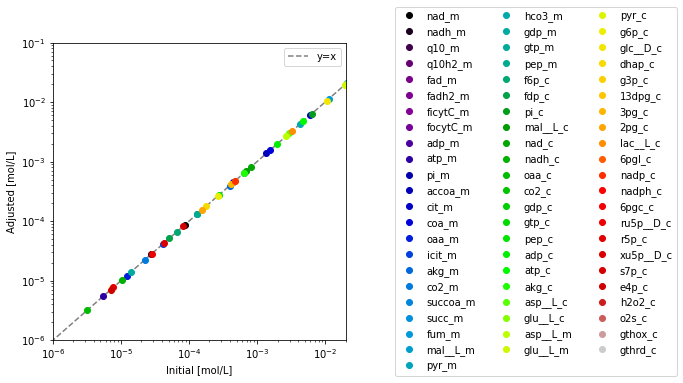

In [243]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_info['conc'], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()


In [ ]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [ ]:
#Compare Results
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info = load_data(
    filepath=csv_ic,
    sheet_name="Concentrations")

In [ ]:
conc_solution.Keqs

In [ ]:
liver.parameters

In [ ]:
# Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

# Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# plot_comparison(
#     x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
#     title="Equilibrium Constants comparison",
#     legend="right outside", plot_function="loglog",
#     xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
#     xy_line=True,
#     xy_legend="best", xlabel="Initial", ylabel="Adjusted")

# Keq_data_comparison_fig.tight_layout()

In [ ]:
liver.reactions.EX_glc__D_c.Keq = 1
liver.reactions.EX_h_c.Keq = 1 
liver.reactions.EX_h2o_c.Keq = 1 
liver.reactions.EX_pi_c.Keq = 1 
liver.reactions.EX_pyr_c.Keq = 1 
liver.reactions.EX_lac__L_c.Keq = 1 
# liver.reactions.EX_nadh_c.Keq = 1 
# liver.reactions.EX_nad_c.Keq = 1 

In [ ]:
liver.boundary_conditions['glc__D_b']=0.010482807 ##M ## initial condition of the metabolite in the model
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=0.0064 ##M
liver.boundary_conditions['pi_b']=0.010482807 ##M
liver.boundary_conditions['pyr_b']=0.00048 ##M
liver.boundary_conditions['nadh_b']=4.63542E-06
liver.boundary_conditions['nad_b']=0.00182531
liver.boundary_conditions['lac__L_b']=0.003261838

In [ ]:
Boundary= [
             "EX_glc__D_c", 
            "EX_h_c", 
            "EX_h2o_c",
            'EX_pyr_c',
            'EX_pi_c',
    "ATPM",
    
#     'EX_nad_c',
    "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [ ]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
#                         or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
#                                 r== glycogenolysis.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
#                                 r== glycogenolysis.reactions.PEPtm or r== glycogenolysis.reactions.GLCt1 
#                                 or r== glycogenolysis.reactions.Ht
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
#function to set x label and y label
def set_x_label(xlabel):
    if xlabel==None:
        xlabel="Time"
    else:
        xlabel=xlabel
    return xlabel
        
def set_y_label(ylabel):        
    if ylabel==None:
        ylabel="Concentrations"
    else:
        ylabel=ylabel
    return ylabel


In [ ]:
#function to make plot typelinear log
def set_plot_type(plot_type):
    if plot_type == None:
        x_plot_type = 'log'
        y_plot_type = 'log'
    elif plot_type == "logx":
        x_plot_type = 'log'
        y_plot_type = 'linear'
    elif plot_type == "logy":
        x_plot_type = 'linear'
        y_plot_type = 'log'
    elif plot_type == "linear":
        x_plot_type = 'linear'
        y_plot_type = 'linear'
    elif plot_type == "logxlogy":
        x_plot_type = 'log'
        y_plot_type = 'log'
    return x_plot_type,y_plot_type


In [ ]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol.to_frame()
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]+["Concentrations"]
    ).properties(width=width, height=height).interactive()

    
    
#         if dynamic == False:
#             A = alt.layer(line)
#         else:
    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [ ]:
view_all_conc_sol(conc_sol,plot_type='logxlogy')